<a href="https://colab.research.google.com/github/mijanr/GANs/blob/master/cGAN_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [4]:
#load the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

In [5]:
batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [6]:
class_list = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_num = len(class_list)

In [7]:
#visualize the dataset
def imshow(dataloader):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    img = torchvision.utils.make_grid(images)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


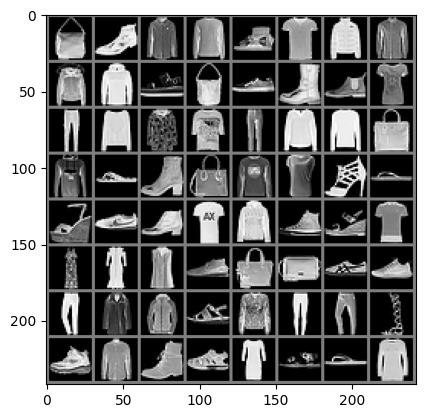

In [8]:
imshow(trainloader)

In [10]:
for images, labels in trainloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [11]:
#Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.embed = nn.Embedding(class_num, class_num)
        #output size = batch_size x 1x 28 x 28
        self.sequential = nn.Sequential(
            nn.ConvTranspose2d(110, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            #flatten
            nn.Flatten(),
            nn.LazyLinear(784),
            nn.Tanh()
        )
    def forward(self, x, label):
        label = self.embed(label)
        label = label.view(label.size(0), label.size(1), 1, 1)
        x = torch.cat((x, label), 1)
        x = self.sequential(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [13]:
generator = Generator().to(device)

/home/pops/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [14]:
#feed a random noise and a label to the generator
noise = torch.randn(64, 100, 1, 1, device=device)
label = torch.randint(0, 10, (64,), device=device)
fake_image = generator(noise, label)
print(fake_image.shape)

torch.Size([64, 1, 28, 28])


In [18]:
#Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.embed = nn.Embedding(class_num, class_num)
        self.sequential = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x, label):
        x = x.view(-1, 784)
        label = self.embed(label)
        x = torch.cat((x, label), 1)
        x = self.sequential(x)
        return x

In [19]:
discriminator = Discriminator().to(device)

In [20]:
#feed the fake image to the discriminator
output = discriminator(fake_image, label)
print(output.shape)

torch.Size([64, 1])


In [21]:
#training
criterion = nn.BCELoss()
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

In [30]:
#training loop
num_epochs = 1000
for epoch in range(num_epochs):
    for images, _ in trainloader:
        #train discriminator
        #real
        discriminator.zero_grad()
        real_label = torch.ones(batch_size, device=device)
        labels = torch.randint(0, 10, (batch_size,), device=device)
        output = discriminator(images, labels).squeeze()
        loss_real = criterion(output, real_label)
        loss_real.backward()
        D_x = output.mean().item()
        #fake
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_label = torch.zeros(batch_size, device=device)
        fake_images = generator(noise, labels)
        output = discriminator(fake_images.detach(), labels).squeeze()
        loss_fake = criterion(output, fake_label)
        loss_fake.backward()
        D_G_z1 = output.mean().item()
        loss_D = loss_real + loss_fake
        optimizerD.step()
        #train generator
        generator.zero_grad()
        output = discriminator(fake_images, labels).squeeze()
        loss_G = criterion(output, real_label)
        loss_G.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
    print('[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' % (epoch, num_epochs, loss_D.item(), loss_G.item(), D_x, D_G_z1, D_G_z2))

KeyboardInterrupt: 

In [ ]:
#gernerate image
noise = torch.randn(64, 100, 1, 1, device=device)
label = torch.randint(0, 10, (64,), device=device)
fake_image = generator(noise, label)
fake_image = fake_image.view(fake_image.size(0), 28, 28)
fake_image = fake_image.cpu().detach().numpy()

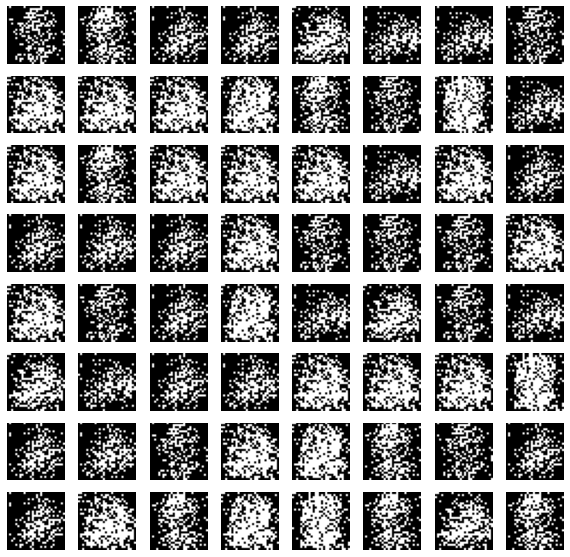

In [18]:
#plot image
plt.figure(figsize=(10, 10))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(fake_image[i], cmap='gray')
    plt.axis('off')
plt.show()